### _CSCN8010-Foundations of Machine Learning_
## **Lab 10 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification**

__Problem Definition__

> This lab compares a custom CNN and fine-tuned VGG16 for dog vs. cat image classification using EDA, various evaluation metrics, and error analysis.

__Dataset__

[Asirra: The Dogs vs. Cats Dataset](https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats)

Load data


In [27]:
import os, shutil, pathlib

Constants

In [28]:
NUMBER_OF_TRAIN_IMAGES = 1000 
NUMBER_OF_TEST_IMAGES = 500 
NUMBER_OF_VALIDATION_IMAGES = 500 

PATH_TRAIN = "../dog_cat/subset_train"
PATH_TEST = "../dog_cat/subset_test"
PATH_VALIDATION = "../dog_cat/subset_validation"

IMAGE_SIZE = 256
BATCH_SIZE = 50

Creating subset for train, validation and test dataset.

In [29]:
source_train_path = pathlib.Path("../dog_cat/train/")

subsets = [
            ("train", 1,NUMBER_OF_TRAIN_IMAGES + 1),
            ("validation", NUMBER_OF_TRAIN_IMAGES + 1, NUMBER_OF_TRAIN_IMAGES + NUMBER_OF_VALIDATION_IMAGES + 1),
            ("test",NUMBER_OF_TRAIN_IMAGES + NUMBER_OF_VALIDATION_IMAGES + 1 ,NUMBER_OF_TRAIN_IMAGES + NUMBER_OF_VALIDATION_IMAGES + NUMBER_OF_TEST_IMAGES+ 1)
        ]

def create_subsets(s):
    (subset, start, end) = s
    for category in ("cat", "dog"):
        dir_subset = pathlib.Path(f"../dog_cat/subset_{subset}/{category}")
        if not dir_subset.is_dir():
            os.makedirs(dir_subset)
        files = [f"{category}.{i}.jpg" for i in range(start, end)]
        for file in files:
            shutil.copyfile(src=source_train_path / file, dst=dir_subset / file)
 
for subset in subsets: create_subsets(subset)       
            

Importing required libraries

In [67]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [31]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TRAIN,
    shuffle= True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_VALIDATION,
    shuffle= True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)
ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TEST,
    shuffle= True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Found 1000 files belonging to 2 classes.


In [58]:
print(f"Length of Training data batches: {len(ds_train)}")
print(f"Length of Validation data batches: {len(ds_validation)}")
print(f"Length of Test data batches: {len(ds_test)}")

Length of Training data batches: 40
Length of Validation data batches: 20
Length of Test data batches: 20


__Visualization__

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in ds_train.take(1):
  for i in range(16):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(ds_train.class_names[labels[i]])

Caching and Prefetching

In [33]:
ds_train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
ds_test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
ds_validation.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### __CNN__

Preprocessing Pipeline

In [34]:
resize_and_rescaling = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

In [35]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [40]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, 3)

model = keras.Sequential([
    resize_and_rescaling,
    data_augmentation,
    Conv2D(32, kernel_size=(3,3), activation="relu", input_shape = input_shape),
    MaxPooling2D((2,2)),
    Conv2D(64, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(128, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(128, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(256, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(64, kernel_size=(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.build(input_shape=input_shape)


In [41]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (50, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (50, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (50, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (50, 62, 62, 64)         0         
 g2D)                                                 

In [42]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [43]:
history = model.fit(ds_train, epochs=50, batch_size=BATCH_SIZE, validation_data= ds_validation)

Epoch 1/50


40/40 [==============================] - 92s 2s/step - loss: 0.6947 - accuracy: 0.4880 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 2/50
40/40 [==============================] - 90s 2s/step - loss: 0.6930 - accuracy: 0.4945 - val_loss: 0.6928 - val_accuracy: 0.5950
Epoch 3/50
40/40 [==============================] - 91s 2s/step - loss: 0.6957 - accuracy: 0.5295 - val_loss: 0.6919 - val_accuracy: 0.5870
Epoch 4/50
40/40 [==============================] - 90s 2s/step - loss: 0.6934 - accuracy: 0.5105 - val_loss: 0.6894 - val_accuracy: 0.5160
Epoch 5/50
40/40 [==============================] - 91s 2s/step - loss: 0.6974 - accuracy: 0.5295 - val_loss: 0.6833 - val_accuracy: 0.5610
Epoch 6/50
40/40 [==============================] - 91s 2s/step - loss: 0.6828 - accuracy: 0.5740 - val_loss: 0.6856 - val_accuracy: 0.5280
Epoch 7/50
40/40 [==============================] - 91s 2s/step - loss: 0.6836 - accuracy: 0.5890 - val_loss: 0.7370 - val_accuracy: 0.5020
Epoch 8/50
40/40 [=============

Saving the model

In [44]:
tf.keras.models.save_model(model, '../models/model.h5', save_format='h5')

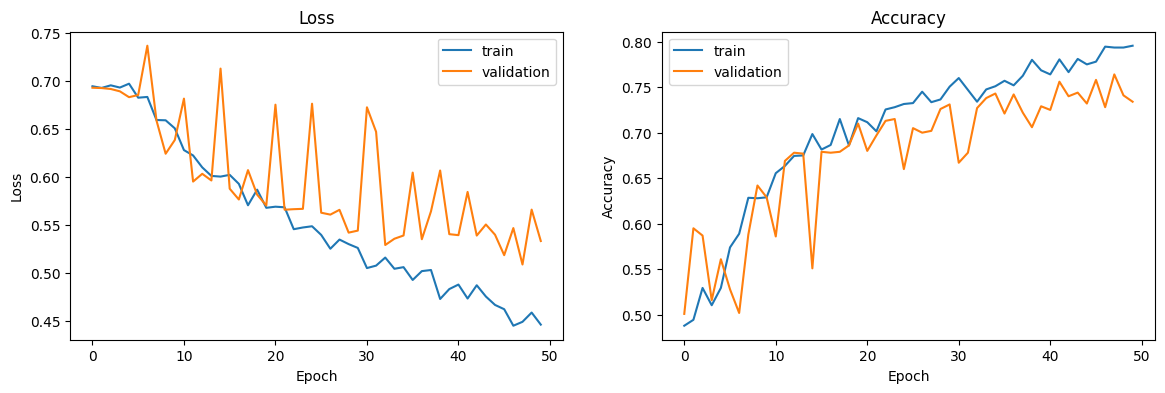

In [63]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Evaluating the Model with the Test Data

In [65]:
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Accuracy on test data: {test_accuracy}")

20/20 [==============================] - 8s 410ms/step - loss: 0.6630 - accuracy: 0.8040
Accuracy on test data: 0.8040000200271606


### __VGG16__


In [48]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam


In [54]:
vgg16 = VGG16(weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), classes=1, include_top=False)
for layer in vgg16.layers:
            layer.trainable = False
            
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

vgg_model = Model(inputs=vgg16.input, outputs=predictions)
vgg_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
vgg_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [61]:
checkpoint_filepath = 'best_model.hdf5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  
    monitor='val_loss',
    mode='min', 
    save_best_only=True)

history_vgg = vgg_model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_validation,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/5


40/40 [==============================] - 286s 7s/step - loss: 0.1478 - accuracy: 0.9735 - val_loss: 0.1838 - val_accuracy: 0.9570
Epoch 2/5
40/40 [==============================] - 331s 8s/step - loss: 0.0506 - accuracy: 0.9780 - val_loss: 0.1207 - val_accuracy: 0.9640
Epoch 3/5
40/40 [==============================] - 609s 15s/step - loss: 0.0382 - accuracy: 0.9875 - val_loss: 0.1203 - val_accuracy: 0.9640
Epoch 4/5
40/40 [==============================] - 371s 9s/step - loss: 0.0321 - accuracy: 0.9910 - val_loss: 0.1495 - val_accuracy: 0.9600
Epoch 5/5
40/40 [==============================] - 307s 8s/step - loss: 0.0230 - accuracy: 0.9930 - val_loss: 0.1487 - val_accuracy: 0.9650


Saving the model

In [62]:
tf.keras.models.save_model(vgg_model, '../models/vgg16.h5', save_format='h5')


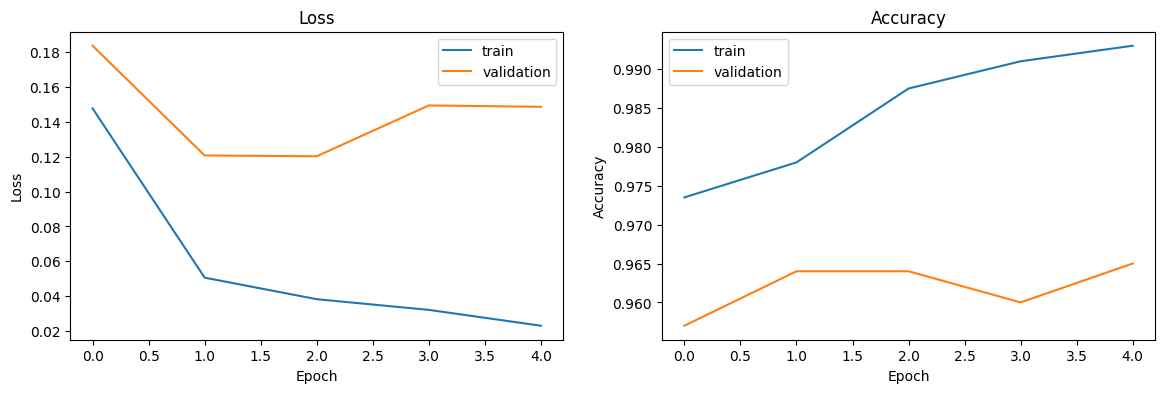

In [64]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history_vgg.history['loss'], label='train')
plt.plot(history_vgg.history['val_loss'], label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history_vgg.history['accuracy'], label='train')
plt.plot(history_vgg.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Evaluating the Model with the Test Data

In [66]:
test_loss, test_accuracy = vgg_model.evaluate(ds_test)
print(f"Accuracy on test data: {test_accuracy}")

20/20 [==============================] - 100s 5s/step - loss: 0.1867 - accuracy: 0.9640
Accuracy on test data: 0.9639999866485596
